In [5]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [6]:
# Preprocess data
# read dataset
df= pd.read_csv("water_potability.csv")

#REF: https://blog.csdn.net/sinat_28442665/article/details/104901143  by molixueAI, March 16, 2020
# Missing values
df.isnull().sum()
df["ph"].fillna(value=df["ph"].mean(),inplace=True)
df["Sulfate"].fillna(value=df["Sulfate"].mean(),inplace=True)
df["Trihalomethanes"].fillna(value=df["Trihalomethanes"].mean(),inplace=True)

# Get the feature columns and label column
water_ingredients = pd.DataFrame(df.iloc[:, 0:9])
water_potability = pd.DataFrame(df.iloc[:, 9])

#REF: https://scikit-learn.org/stable/modules/preprocessing.html
# Standard data
scaler = preprocessing.StandardScaler().fit(water_ingredients)
ingredients_scaled = scaler.transform(water_ingredients)
ingredients_scaled = pd.DataFrame(ingredients_scaled)

#REF: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
# LOF detect outliers and remove them
lof = LocalOutlierFactor(n_neighbors=2)
output = lof.fit_predict(ingredients_scaled)

# Count is the index of outliers, count1 is the number of outliers
count = 0
count1 = 0
for i in output:
    count = count + 1
    if i == -1:
        count1 = count1 + 1
        ingredients_scaled.drop(count - 1, axis=0, inplace=True)
        water_potability.drop(count - 1, axis=0, inplace=True)

print("Outlier number: ", count1)

# Combine the preprocessed data and export
ingredients_scaled['result'] = water_potability
preprocessed_data = ingredients_scaled
preprocessed_data.to_csv('preprocessed_data.csv')



Outlier number:  121


In [7]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns 


50  Epochs:
Training time:  20.90113091468811 s


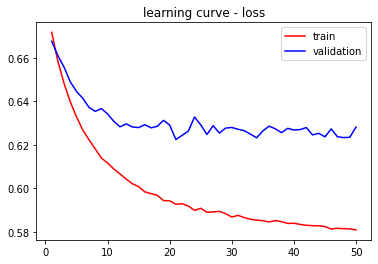

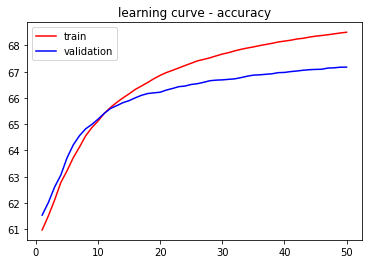

Accuracy of the network on the test set: 67.40506329113924 %


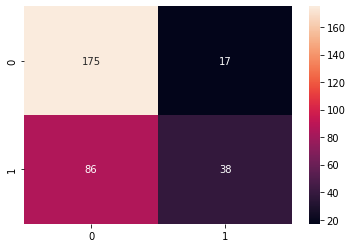

100  Epochs:
Training time:  41.442200899124146 s


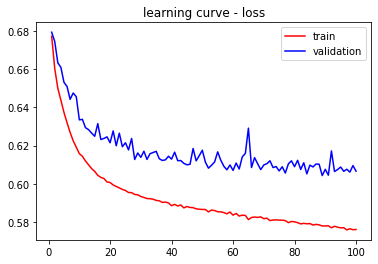

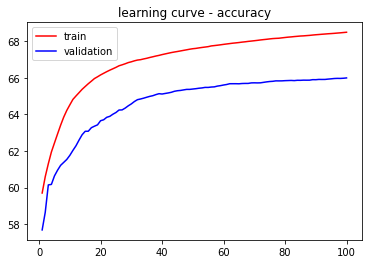

Accuracy of the network on the test set: 68.35443037974683 %


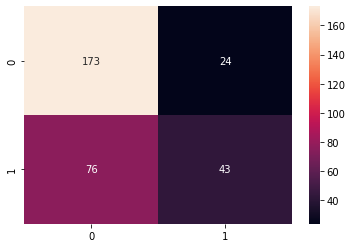

150  Epochs:
Training time:  62.10692477226257 s


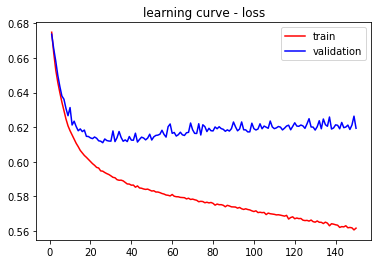

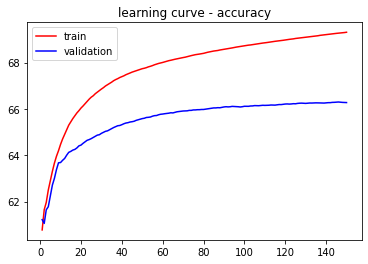

Accuracy of the network on the test set: 66.77215189873418 %


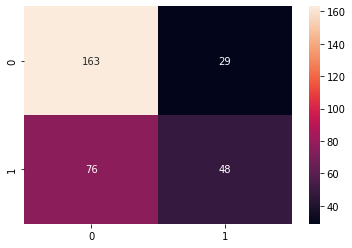

200  Epochs:
Training time:  80.06274819374084 s


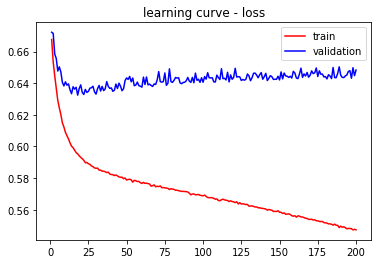

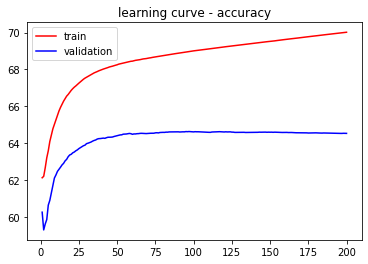

Accuracy of the network on the test set: 69.62025316455696 %


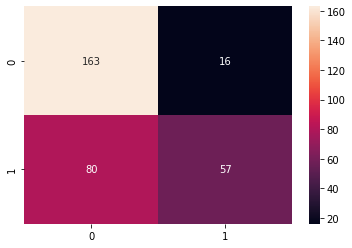

In [8]:
#REF: https://blog.csdn.net/qq_37554556/article/details/115038669  by maomaozhennice,March 21, 2021  
# find best epoch number for [50, 200]
for n in range(50, 250, 50):
  
  # Set Hyper-parameters
  num_epochs = n
  hidden_size = 1000
  num_classes = 2
  batch_size = 4
  learning_rate = 0.0005
  input_size = 9

  # Get dataframe and set the column names
  df = pd.read_csv('preprocessed_data.csv')
  feature_name = ['0','1','2','3','4','5','6','7','8']

  y=df.pop("result")
  x=df[feature_name].copy()

  # Split train, test, validation data
  x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size = 0.2)
  x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5)

  train_set = TensorDataset(torch.from_numpy(x_train.values).to(torch.float32),torch.from_numpy(y_train.values).to(torch.float32))
  test_set = TensorDataset(torch.from_numpy(x_test.values).to(torch.float32),torch.from_numpy( y_test.values).to(torch.float32))
  validation_set = TensorDataset(torch.from_numpy(x_val.values).to(torch.float32),torch.from_numpy( y_val.values).to(torch.float32))


  #transform numpy data to tensor
  train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True,drop_last=True)
  test_loader = DataLoader(test_set, batch_size=batch_size,drop_last=True)
  validation_loader = DataLoader(validation_set, batch_size=batch_size,drop_last=True)



  # Fully connected neural network with one hidden layer
  class NeuralNet(nn.Module):
      def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

      def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

  # 
  model = NeuralNet(input_size, hidden_size, num_classes)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Train the model
  total = 0
  correct = 0
  total_step = len(train_loader)
  loss_vals=  []
  accuracy = []

  # validate the model
  correct_validate = 0
  total_validate = 0
  loss_vals_validate = []
  accuracy_validate = []

  start_time = time.time()
  
  for epoch in range(num_epochs):

    epoch_loss= []
    for i, (data, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        data = data.reshape(-1, input_size)
        labels = labels

        # Forward pass
        outputs = model(data)

        labels = labels.type(torch.LongTensor)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy.append(100 * correct / total)
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))

    
    # validate
    epoch_loss_validate = []
    for data_validate, labels_validate in validation_loader:
        
        data_validate = data_validate.reshape(-1, input_size)
        labels_validate = labels_validate

        outputs_validate = model(data_validate)

        labels_validate = labels_validate.type(torch.LongTensor)

        loss_validate = criterion(outputs_validate, labels_validate)
        epoch_loss_validate.append(loss_validate.item())

        _, predicted_validate = torch.max(outputs_validate.data, 1)
        total_validate += labels_validate.size(0)
        correct_validate += (predicted_validate == labels_validate).sum().item()


    accuracy_validate.append(100 * correct_validate / total_validate)
    loss_vals_validate.append(sum(epoch_loss_validate)/len(epoch_loss_validate))


  train_duration = time.time() - start_time
  print(n, ' Epochs:\nTraining time: ', train_duration, 's')

  # REF: https://blog.csdn.net/qq_36523839/article/details/82556932  by bulunruheweilaihenmeihao, September 9, 2018
  # REF: https://blog.csdn.net/weixin_37659245/article/details/98962849  by caijideziwozhengjiu, August 9, 2019
  # loss
  plt.title('learning curve - loss')
  plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals, '-', color='r', label='train')
  plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals_validate, '-', color='b', label='validation')
  plt.legend()
  plt.show()

  # accuracy
  plt.title('learning curve - accuracy')
  plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), accuracy, '-', color='r', label='train')
  plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), accuracy_validate, '-', color='b', label='validation')
  plt.legend()
  plt.show()
  

  # Test the model
  with torch.no_grad():
    correct = 0
    total = 0
    loss_vals_test = []
    accuracy_test = []
    y_pred = []
    y_true = []

    for data, labels in test_loader:
        
        data = data.reshape(-1, input_size)
        labels = labels
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)

        y_pred += predicted.numpy().tolist()
        y_true += labels.numpy().tolist()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test set:', 100 * correct / total, '%')


  # plot the confusion matrix and heatmap
  C = confusion_matrix(y_true, y_pred)
  df=pd.DataFrame(C)
  sns.heatmap(df,annot=True, fmt='.20g')
  plt.show()
    